## Setup

### Connect to Google Drive

In [ ]:
# Colab library to upload files to notebook
from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive')

# changing the working directory
%cd /content/gdrive/My Drive/Skripsi Fadia
# Check the present working directory using pwd command

Mounted at /content/gdrive
/content/gdrive/My Drive/Skripsi Fadia


### Define data folder path

In [ ]:
# Data kaggle yg udah dibersihin
trainpath = "/content/gdrive/My Drive/Skripsi Fadia/Data/Train"
valpath = "/content/gdrive/My Drive/Skripsi Fadia/Data/Validation"
testpath = "/content/gdrive/My Drive/Skripsi Fadia/Data/Test"

### Import libraries

In [ ]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.applications.densenet import DenseNet201
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from sklearn.preprocessing import LabelBinarizer

!pip install keras-tuner
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from keras import models, layers
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.densenet import preprocess_input
from matplotlib import pyplot

     |████████████████████████████████| 71kB 3.7MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78935 sha256=bd2ef9997f2476355b0225633146a35447edd3445c7f83da479943acc084fe25
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=3cad96317af99cc75bf1264265cdf218dbb79c6e59d37a03652c512c0b68ca17
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


### Define parameters

In [ ]:
img_width = 256
img_height = 256
INPUT_SHAPE = (img_width, img_height, 3)
NUM_CLASSES = 2
SEED = 42

num_of_train_samples = 1007
num_of_val_samples = 288

####### For training #######
EPOCH = 200

# batch size : total number of images passed to the model per iteration
BATCH_SIZE = 32

# steps per epoch : iteration per epoch
STEPS_PER_EPOCH = num_of_train_samples // BATCH_SIZE   # amount of images in train set = 1007

####### For random search (hyperparameter tuning) #######
MAX_TRIALS = 10
EXECUTION_PER_TRIAL = 1
N_EPOCH_SEARCH = 20

## Data

### Define augmentation

In [ ]:
# Normalization, Augmentation techniques
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=45,
                                   shear_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   fill_mode='nearest')

test_datagen= ImageDataGenerator(rescale=1./255)

### Generate data train

In [ ]:
# Image augmentation : Train set
train_generator = train_datagen.flow_from_directory(trainpath, target_size=(img_width, img_height),
                                           class_mode='categorical', seed=SEED, save_to_dir='Augmentation Result/Train')

Found 1007 images belonging to 2 classes.


In [ ]:
train_generator.next()

(array([[[[0.94653463, 0.94653463, 0.94653463],
          [0.8855214 , 0.8855214 , 0.8855214 ],
          [0.8349993 , 0.8349993 , 0.8349993 ],
          ...,
          [0.32242915, 0.32242915, 0.32242915],
          [0.32666925, 0.32666925, 0.32666925],
          [0.33550093, 0.33550093, 0.33550093]],
 
         [[0.98195165, 0.98195165, 0.98195165],
          [0.9138551 , 0.9138551 , 0.9138551 ],
          [0.8580204 , 0.8580204 , 0.8580204 ],
          ...,
          [0.33533236, 0.33533236, 0.33533236],
          [0.34416407, 0.34416407, 0.34416407],
          [0.3435185 , 0.3435185 , 0.3435185 ]],
 
         [[1.        , 1.        , 1.        ],
          [0.94734365, 0.94734365, 0.94734365],
          [0.8861687 , 0.8861687 , 0.8861687 ],
          ...,
          [0.34355223, 0.34355223, 0.34355223],
          [0.34178588, 0.34178588, 0.34178588],
          [0.3388626 , 0.3388626 , 0.3388626 ]],
 
         ...,
 
         [[0.997609  , 0.997609  , 0.997609  ],
          [0.99937

### Generate data validation

In [ ]:
val_generator = train_datagen.flow_from_directory(valpath, target_size=(img_width, img_height),
                                           class_mode='categorical', seed=SEED, save_to_dir='Augmentation Result/Validation')

Found 288 images belonging to 2 classes.


In [ ]:
val_generator.next()

(array([[[[0.882353  , 0.882353  , 0.882353  ],
          [0.882353  , 0.882353  , 0.882353  ],
          [0.882353  , 0.882353  , 0.882353  ],
          ...,
          [0.89853346, 0.89853346, 0.89853346],
          [0.94338495, 0.94338495, 0.94338495],
          [0.9828441 , 0.9828441 , 0.9828441 ]],
 
         [[0.8805829 , 0.8805829 , 0.8805829 ],
          [0.882353  , 0.882353  , 0.882353  ],
          [0.882353  , 0.882353  , 0.882353  ],
          ...,
          [0.942513  , 0.942513  , 0.942513  ],
          [0.98208123, 0.98208123, 0.98208123],
          [1.        , 1.        , 1.        ]],
 
         [[0.87778586, 0.87778586, 0.87778586],
          [0.8805283 , 0.8805283 , 0.8805283 ],
          [0.882353  , 0.882353  , 0.882353  ],
          ...,
          [0.9813183 , 0.9813183 , 0.9813183 ],
          [1.        , 1.        , 1.        ],
          [0.9989487 , 0.9989487 , 0.9989487 ]],
 
         ...,
 
         [[1.        , 1.        , 1.        ],
          [1.     

### Generate data test

In [ ]:
test_generator = test_datagen.flow_from_directory(testpath, target_size=(img_width, img_height),
                                           class_mode='categorical', seed=SEED, shuffle=False)

Found 167 images belonging to 2 classes.


In [ ]:
# covid_path1 = "Data/Train/COVID-19/AnotaGÇí+¦o 2020-04-28 103256.png"
# covid_img1 = image.load_img(covid_path1, target_size=(img_width, img_height))  
# covid1 = image.img_to_array(covid_img1)                           
# covid1 = np.expand_dims(covid1, axis=0)                  
# covid1 /= 255.0

# covid_path2 = "Data/Train/COVID-19/AnotaGÇí+¦o 2020-04-28 133056.png"
# covid_img2 = image.load_img(covid_path2, target_size=(img_width, img_height))  
# covid2 = image.img_to_array(covid_img2)                           
# covid2 = np.expand_dims(covid2, axis=0)                  
# covid2 /= 255.0

# covid_path3 = "Data/Train/COVID-19/AnotaGÇí+¦o 2020-04-28 141358.png"
# covid_img3 = image.load_img(covid_path3, target_size=(img_width, img_height))  
# covid3 = image.img_to_array(covid_img3)                           
# covid3 = np.expand_dims(covid3, axis=0)                  
# covid3 /= 255.0

# covid_path4 = "Data/Test/COVID-19/AnotaGÇí+¦o 2020-05-04 153415.png"
# covid_img4 = image.load_img(covid_path4, target_size=(img_width, img_height))  
# covid4 = image.img_to_array(covid_img4)                           
# covid4 = np.expand_dims(covid4, axis=0)                  
# covid4 /= 255.0

# covid_path5 = "Data/Test/COVID-19/AnotaGÇí+¦o 2020-05-04 153712.png"
# covid_img5 = image.load_img(covid_path5, target_size=(img_width, img_height))  
# covid5 = image.img_to_array(covid_img5)                           
# covid5 = np.expand_dims(covid5, axis=0)                  
# covid5 /= 255.0

In [ ]:
# noncovid_path1 = "Test/Non-COVID-19/Captura de Tela 2020-06-02 +ás 16.39.27.png"
# noncovid_img1 = image.load_img(noncovid_path1, target_size=(img_width, img_height))  
# noncovid1 = image.img_to_array(noncovid_img1)                           
# noncovid1 = np.expand_dims(noncovid1, axis=0)                  
# noncovid1 /= 255.0

# noncovid_path2 = "Test/Non-COVID-19/Captura de Tela 2020-06-02 +ás 11.13.52.png"
# noncovid_img2 = image.load_img(noncovid_path2, target_size=(img_width, img_height))  
# noncovid2 = image.img_to_array(noncovid_img2)                           
# noncovid2 = np.expand_dims(noncovid2, axis=0)                  
# noncovid2 /= 255.0

# noncovid_path3 = "Test/Non-COVID-19/Captura de Tela 2020-06-02 +ás 09.06.51.png"
# noncovid_img3 = image.load_img(noncovid_path3, target_size=(img_width, img_height))  
# noncovid3 = image.img_to_array(noncovid_img3)                           
# noncovid3 = np.expand_dims(noncovid3, axis=0)                  
# noncovid3 /= 255.0

# noncovid_path4 = "Test/Non-COVID-19/Captura de Tela 2020-05-30 +ás 04.07.09.png"
# noncovid_img4 = image.load_img(noncovid_path4, target_size=(img_width, img_height))  
# noncovid4 = image.img_to_array(noncovid_img4)                           
# noncovid4 = np.expand_dims(noncovid4, axis=0)                  
# noncovid4 /= 255.0

# noncovid_path5 = "Test/Non-COVID-19/Captura de Tela 2020-06-02 +ás 16.39.58.png"
# noncovid_img5 = image.load_img(noncovid_path5, target_size=(img_width, img_height))  
# noncovid5 = image.img_to_array(noncovid_img5)                           
# noncovid5 = np.expand_dims(noncovid5, axis=0)                  
# noncovid5 /= 255.0

In [ ]:
# We need to generate feature maps of only convolution layers and not dense layers and 
# hence we will generate feature maps of layers that have “dimension=4″.

# Each feature map has n-channels and this number “n” is given at the end of the shape of the feature map. This is the number of features in a particular layer.

# For eg. feature_map[0].shape = (1,148,148,8). This means this is an image with 8 dimensions. 
# So, we need to iterate over this image to separate its 8 images. 
# This shows that layer_1 output has 8 features which have been clubbed into 1 image.

# The feature maps directly generated are very dim in visual and hence not properly visible to human eyes. 
# So, we need to do Standardization and Normalization of the feature image extracted.

def generate_feature_map(layername, featuremap):
  for layer_name, feature_map in zip(layername, featuremap):  
    if len(feature_map.shape) == 4:
      k = feature_map.shape[-1]  
      size = feature_map.shape[1]
      # We will tile our images in this matrix
      display_grid = np.zeros((size, size * k))

      # Postprocess the feature to be visually palatable
      for i in range(k):
        feature_image = feature_map[0, :, :, i]
        feature_image -= feature_image.mean()
        feature_image /= feature_image.std ()
        feature_image *=  64
        feature_image += 128
        feature_image = np.clip(feature_image, 0, 255).astype('uint8')
        display_grid[:, i * size : (i + 1) * size] = feature_image

      # Display the grid
      scale = 20. / k
      plt.figure(figsize=(scale * k, scale))
      plt.title(layer_name)
      plt.grid(False)
      plt.imshow(display_grid, aspect='auto', cmap='viridis')

## Model

### Architecture - Build hyper model

In [ ]:
###### Model with hyperparameter tuning ######

class cnnHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    # define search space
    def build(self, hp):
        # pre-trained model
        convModel = DenseNet201(include_top=False, 
                        weights='imagenet', 
                        input_shape=INPUT_SHAPE)

        # add layers
        model = Sequential()
        model.add(convModel)

        # average pooling layer
        model.add(AveragePooling2D(pool_size=(2,2)))

        # flatten
        model.add(Flatten())

        # dense layer 1
        model.add(
            Dense(
                units=hp.Int(
                    'units_1',
                    min_value=32,
                    max_value=512,
                    step=32,
                    default=128
                ),
                activation=hp.Choice(
                    'dense_activation_1',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'
                )
            )
        )

        # dropout layer 1
        model.add(
            Dropout(
                rate=hp.Float(
                    'dropout_1',
                    min_value=0.05,
                    max_value=0.5,
                    default=0.2,
                    step=0.05
                )
            )
        )

        # dense layer 2
        model.add(
            Dense(
                units=hp.Int(
                    'units_2',
                    min_value=32,
                    max_value=512,
                    step=32,
                    default=64
                ),
                activation=hp.Choice(
                    'dense_activation_2',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'
                )
            )
        )

        # dropout layer 2
        model.add(
            Dropout(
                rate=hp.Float(
                    'dropout_2',
                    min_value=0.05,
                    max_value=0.5,
                    default=0.3,
                    step=0.05
                )
            )
        )

        # dense layer 3 (last)
        model.add(Dense(self.num_classes, activation='sigmoid'))

        # loop over all layers in the base model and freeze them so they will
        # *not* be updated during the first training process
        for layer in convModel.layers:
          layer.trainable = False

        # compile model
        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Float(
                    'learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG',
                    default=1e-4
                )
            ),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return model

hypermodel = cnnHyperModel(INPUT_SHAPE, NUM_CLASSES)

### Define tuner and search space

In [ ]:
# random search tuner
tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    seed=SEED,
    max_trials=MAX_TRIALS,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='Random Search Result',
    project_name='Final_densenet201_COVID-19')

# tuner search space summary
tuner.search_space_summary()

74842112/74836368 [==============================] - 2s 0us/step
Search space summary
Default search space size: 7
units_1 (Int)
{'default': 128, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dense_activation_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
dropout_1 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.05, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
units_2 (Int)
{'default': 64, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dense_activation_2 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
dropout_2 (Float)
{'default': 0.3, 'conditions': [], 'min_value': 0.05, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


### Start hyperparameter tuning

In [ ]:
# start searching
tuner.search(train_generator,
             epochs=N_EPOCH_SEARCH,
             validation_data=val_generator)

Trial 10 Complete [00h 10m 51s]
val_accuracy: 0.9444444179534912

Best val_accuracy So Far: 0.9756944179534912
Total elapsed time: 02h 00m 43s
INFO:tensorflow:Oracle triggered exit


### Get best model

In [ ]:
# get best model
model1 = tuner.get_best_models(num_models=1)[0]

# model summary
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 8, 8, 1920)        18321984  
_________________________________________________________________
average_pooling2d (AveragePo (None, 4, 4, 1920)        0         
_________________________________________________________________
flatten (Flatten)            (None, 30720)             0         
_________________________________________________________________
dense (Dense)                (None, 352)               10813792  
_________________________________________________________________
dropout (Dropout)            (None, 352)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 160)               56480     
_________________________________________________________________
dropout_1 (Dropout)          (None, 160)               0

### Training

In [ ]:
history1 = model1.fit_generator(train_generator, 
                              epochs=EPOCH, 
                              validation_data=val_generator, 
                              steps_per_epoch=STEPS_PER_EPOCH)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
31/31 [==============================] - 46s 1s/step - loss: 0.1191 - accuracy: 0.9661 - val_loss: 0.1039 - val_accuracy: 0.9618
Epoch 2/200
31/31 [==============================] - 30s 980ms/step - loss: 0.1397 - accuracy: 0.9552 - val_loss: 0.1117 - val_accuracy: 0.9583
Epoch 3/200
31/31 [==============================] - 31s 985ms/step - loss: 0.1157 - accuracy: 0.9615 - val_loss: 0.1855 - val_accuracy: 0.9306
Epoch 4/200
31/31 [==============================] - 31s 985ms/step - loss: 0.1123 - accuracy: 0.9654 - val_loss: 0.1443 - val_accuracy: 0.9479
Epoch 5/200
31/31 [==============================] - 31s 983ms/step - loss: 0.0901 - accuracy: 0.9689 - val_loss: 0.1199 - val_accuracy: 0.9479
Epoch 6/200
31/31 [==============================] - 31s 984ms/step - loss: 0.1200 - accuracy: 0.9619 - val_loss: 0.1854 - val_accuracy: 0.9375
Epoch 7/200
31/31 [==============================] - 31s 987ms/step - loss: 0.0836 - accuracy: 0.9742 - val_loss: 0.1198 - val_accuracy: 0.

### Save model

In [ ]:
# save model
model1.save('Model/FinalModel_DenseCov.hd5')

INFO:tensorflow:Assets written to: Model/FinalModel_DenseCov.hd5/assets


## Model performance

### Training visualization

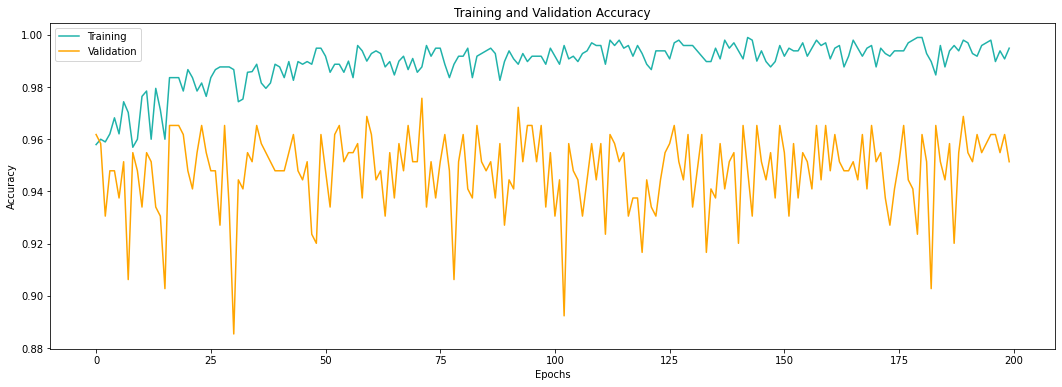

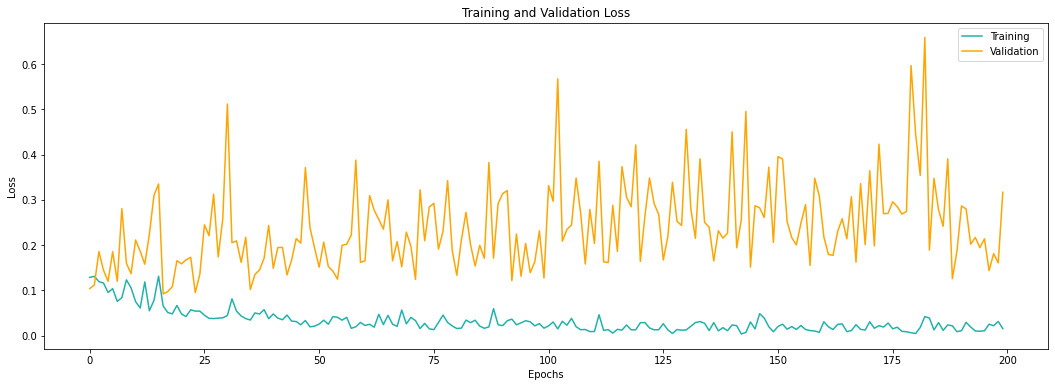

In [ ]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

# Accuracy
plt.figure(figsize=(18,6))
plt.plot(epochs, acc, 'lightseagreen', label='Training')
plt.plot(epochs, val_acc, 'orange', label='Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("Final1 Accuracy Performance.png")

plt.figure(figsize=(18,6))

# Loss
plt.plot(epochs, loss, 'lightseagreen', label='Training')
plt.plot(epochs, val_loss, 'orange', label='Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("Final1 Loss Performance.png")

plt.show()

### Average accuracy and loss

In [ ]:
avg_accuracy = np.mean(history1.history['accuracy'])
avg_accuracy

0.989205539226532

In [ ]:
avg_val_accuracy = np.mean(history1.history['val_accuracy'])
avg_val_accuracy

0.9479861146211624

In [ ]:
avg_loss = np.mean(history1.history['loss'])
avg_loss

0.03187948502134532

In [ ]:
avg_val_loss = np.mean(history1.history['val_loss'])
avg_val_loss

0.23978278115391732

## Prediction

### Predict data test

In [ ]:
model = keras.models.load_model("Model/FinalModel_DenseCov.hd5")

In [ ]:
prob = model.predict_generator(test_generator, 167//BATCH_SIZE+1)
predicted_class_indices = np.argmax(prob, axis=1)
labels = (test_generator.class_indices)
labels2 = dict((v,k) for k,v in labels.items())
predictions = [labels2[k] for k in predicted_class_indices]
print(predicted_class_indices)
print(labels)
print(predictions)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0
 1 1 0 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
{'COVID-19': 0, 'Non-COVID-19': 1}
['COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 

### Classification report

In [ ]:
# Confution Matrix and Classification Report
cf = confusion_matrix(test_generator.classes, predicted_class_indices)
print('Confusion Matrix')
print('-------------------------')
print(cf)

print('\n')

print('Classification Report')
print('-------------------------')
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes, predicted_class_indices, target_names=target_names))

Confusion Matrix
-------------------------
[[81  6]
 [ 5 75]]


Classification Report
-------------------------
              precision    recall  f1-score   support

    COVID-19       0.94      0.93      0.94        87
Non-COVID-19       0.93      0.94      0.93        80

    accuracy                           0.93       167
   macro avg       0.93      0.93      0.93       167
weighted avg       0.93      0.93      0.93       167



### Confusion matrix

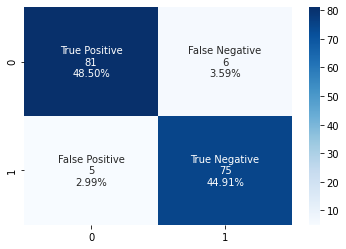

In [ ]:
group_names = ['True Positive', 'False Negative', 'False Positive', 'True Negative']

group_counts = ["{0:0.0f}".format(value) for value in cf.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]

labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(cf, annot=labels, fmt='', cmap='Blues')

### ROC Curve

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(test_generator.classes, predicted_class_indices)

In [ ]:
from sklearn.metrics import auc
auc = auc(fpr, tpr)

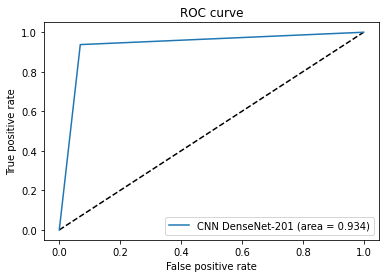

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='CNN DenseNet-201 (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Feature maps analysis

### Load pre-trained DenseNet-201

In [ ]:
densenetmodel = DenseNet201(include_top=False, 
                        weights='imagenet', 
                        input_shape=INPUT_SHAPE)

74850304/74836368 [==============================] - 1s 0us/step


In [ ]:
densenetmodel.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

### Get the convolutional layer

In [ ]:
# Summarize filter shapes
# for layer in densenetmodel.layers:
# 	# Check for convolutional layer
# 	if 'conv' not in layer.name:
# 		continue
# 	# Get filter weights
# 	filters = layer.get_weights()
# 	print(layer.name, np.array(filters).shape)

# Summarize feature map shapes
for i in range(len(densenetmodel.layers)):
	layer = densenetmodel.layers[i]
	# Check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# Summarize output shape
	print(i, layer.name, layer.output.shape)

2 conv1/conv (None, 128, 128, 64)
3 conv1/bn (None, 128, 128, 64)
4 conv1/relu (None, 128, 128, 64)
7 conv2_block1_0_bn (None, 64, 64, 64)
8 conv2_block1_0_relu (None, 64, 64, 64)
9 conv2_block1_1_conv (None, 64, 64, 128)
10 conv2_block1_1_bn (None, 64, 64, 128)
11 conv2_block1_1_relu (None, 64, 64, 128)
12 conv2_block1_2_conv (None, 64, 64, 32)
13 conv2_block1_concat (None, 64, 64, 96)
14 conv2_block2_0_bn (None, 64, 64, 96)
15 conv2_block2_0_relu (None, 64, 64, 96)
16 conv2_block2_1_conv (None, 64, 64, 128)
17 conv2_block2_1_bn (None, 64, 64, 128)
18 conv2_block2_1_relu (None, 64, 64, 128)
19 conv2_block2_2_conv (None, 64, 64, 32)
20 conv2_block2_concat (None, 64, 64, 128)
21 conv2_block3_0_bn (None, 64, 64, 128)
22 conv2_block3_0_relu (None, 64, 64, 128)
23 conv2_block3_1_conv (None, 64, 64, 128)
24 conv2_block3_1_bn (None, 64, 64, 128)
25 conv2_block3_1_relu (None, 64, 64, 128)
26 conv2_block3_2_conv (None, 64, 64, 32)
27 conv2_block3_concat (None, 64, 64, 160)
28 conv2_block4_0_bn

In [ ]:
# # Redefine model to output every dense block
# block1 = models.Model(inputs=densenetmodel.inputs, outputs=densenetmodel.layers[48].output)
# block2 = models.Model(inputs=densenetmodel.inputs, outputs=densenetmodel.layers[136].output)
# block3 = models.Model(inputs=densenetmodel.inputs, outputs=densenetmodel.layers[476].output)
# block4 = models.Model(inputs=densenetmodel.inputs, outputs=densenetmodel.layers[704].output)

### Function to generate feature maps

In [ ]:
def generate_feature_maps(image_path):
  # redefine model to output right after the first hidden layer
  blocks = [2, 48, 136, 476, 704]
  outputs = [densenetmodel.layers[i].output for i in blocks]
  model = models.Model(inputs=densenetmodel.inputs, outputs=outputs)

  # Load the image with the required shape
  image = load_img(image_path, target_size=(256, 256))

  # The image PIL object needs to be converted to a NumPy array of pixel data
  # and expanded from a 3D array to a 4D array with the dimensions of
  # [samples, rows, cols, channels], where we only have one sample.

  # Convert the image to an array
  image = img_to_array(image)

  # Expand dimensions so that it represents a single 'sample'
  image = np.expand_dims(image, axis=0)

  # Prepare the image (e.g. scale pixel values for the densenet)
  image = preprocess_input(image)

  feature_maps = model.predict(image)
  # plot the output from each block
  square = 8
  for fmap in feature_maps:
    # plot all 64 maps in an 8x8 squares
    plt.figure(figsize=(12, 12))
    idx = 1
    for _ in range(square):
      for _ in range(square):
        # specify subplot and turn of axis
        ax = pyplot.subplot(square, square, idx)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(fmap[0, :, :, idx-1], cmap='viridis')
        idx += 1
    # show the figure
    pyplot.show()

In [ ]:
def generate_feature_maps(image_path, layer):
  # redefine model to output right after the first hidden layer
  # blocks = [48, 136, 476, 704]
  outputs = densenetmodel.layers[layer].output
  model = models.Model(inputs=densenetmodel.inputs, outputs=outputs)

  # Load the image with the required shape
  image = load_img(image_path, target_size=(256, 256))

  # The image PIL object needs to be converted to a NumPy array of pixel data
  # and expanded from a 3D array to a 4D array with the dimensions of
  # [samples, rows, cols, channels], where we only have one sample.

  # Convert the image to an array
  image = img_to_array(image)

  # Expand dimensions so that it represents a single 'sample'
  image = np.expand_dims(image, axis=0)

  # Prepare the image (e.g. scale pixel values for the densenet)
  image = preprocess_input(image)

  feature_maps = model.predict(image)
  # k = feature_maps.shape[-1]
  # size = feature_maps.shape[-1]
  # print(size)
  # # We will tile our images in this matrix
  # display_grid = np.zeros((size, size*k))

  # # Postprocess the feature to be visually palatable
  # for i in range(k):
  #   feature_image = feature_maps[0, :, :, i]
  #   feature_image -= feature_image.mean()
  #   feature_image /= feature_image.std()
  #   feature_image *= 64
  #   feature_image += 128
  #   feature_image = np.clip(feature_image, 0, 255).astype('uint8')
  #   print(feature_image.shape)
  #   plt.imshow(feature_image, aspect='auto', cmap='viridis')
  #   display_grid[:, i*size:(i+1)*size] = feature_image

  # # Display the grid
  # scale = 20. / k
  # plt.figure(figsize=(scale * k, scale))
  # # plt.title(layer_name)
  # plt.grid(False)
  # plt.imshow(display_grid, aspect='auto', cmap='viridis')
  for fmap in feature_maps:
    pyplot.imshow(fmap[0, :, :], cmap='viridis')
    pyplot.show()

  # # plot the output from each block
  # square = 8
  # for fmap in feature_maps:
  #   # plot all 64 maps in an 8x8 squares
  #   idx = 1
  #   for _ in range(square):
  #     for _ in range(square):
  #       # specify subplot and turn of axis
  #       ax = pyplot.subplot(square, square, idx)
  #       ax.set_xticks([])
  #       ax.set_yticks([])
  #       # plot filter channel in grayscale
  #       pyplot.imshow(fmap[0, :, :, idx-1], cmap='viridis')
  #       idx += 1
  #   # show the figure
  #   pyplot.show()

In [ ]:
covid_path1 = "Data/Train/COVID-19/AnotaGÇí+¦o 2020-04-28 133322.png"
covid_img1 = image.load_img(covid_path1, target_size=(img_width, img_height))  
covid1 = image.img_to_array(covid_img1)                           
covid1 = np.expand_dims(covid1, axis=0)                  
covid1 /= 255.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


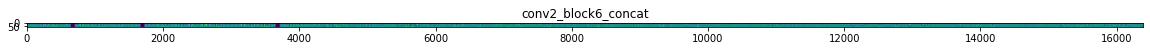

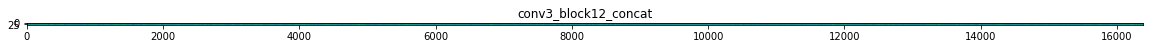

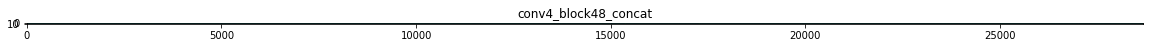

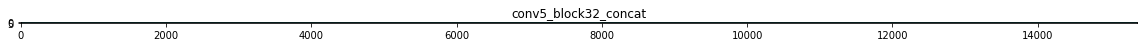

In [ ]:
fmap_covid_1 = generate_feature_map(layer_names, feature_maps_cov1)

### Define image path

In [ ]:
# # Data Test
# cov1 = 'Data/Test/COVID-19/AnotaGÇí+¦o 2020-04-29 192252.png'
# cov2 = 'Data/Test/COVID-19/AnotaGÇí+¦o 2020-05-04 153550.png'
# cov3 = 'Data/Test/COVID-19/AnotaGÇí+¦o 2020-05-05 215929.png'
# noncov1 = 'Data/Test/Non-COVID-19/Captura de Tela 2020-06-02 +ás 09.06.11.png'
# noncov2 = 'Data/Test/Non-COVID-19/Captura de Tela 2020-05-30 +ás 04.42.34.png'
# noncov3 = 'Data/Test/Non-COVID-19/Captura de Tela 2020-06-02 +ás 16.39.11.png'

# Data Train
cov1 = 'Data/Train/COVID-19/AnotaGÇí+¦o 2020-04-28 133322.png'
cov2 = 'Data/Train/COVID-19/AnotaGÇí+¦o 2020-04-28 141854.png'
cov3 = 'Data/Train/COVID-19/AnotaGÇí+¦o 2020-04-29 211704.png'
noncov1 = 'Data/Train/Non-COVID-19/Captura de Tela 2020-06-01 +ás 20.59.34.png'
noncov2 = 'Data/Train/Non-COVID-19/Captura de Tela 2020-06-02 +ás 08.34.16.png'
noncov3 = 'Data/Train/Non-COVID-19/Captura de Tela 2020-05-30 +ás 11.15.59.png'

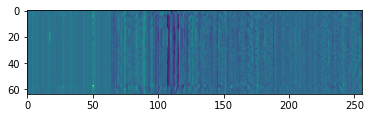

In [ ]:
baru = generate_feature_maps(cov1, 48)

### COVID-19 (Train)

In [ ]:
fm_covid1 = generate_feature_maps(cov1)

In [ ]:
fm_covid2 = generate_feature_maps(cov2)

In [ ]:
fm_covid3 = generate_feature_maps(cov3)

### Non-COVID-19 (Train)

In [ ]:
fm_noncovid1 = generate_feature_maps(noncov1)

In [ ]:
fm_noncovid2 = generate_feature_maps(noncov2)

In [ ]:
fm_noncovid3 = generate_feature_maps(noncov3)

### COVID-19 (Test)

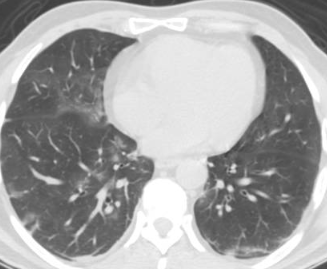

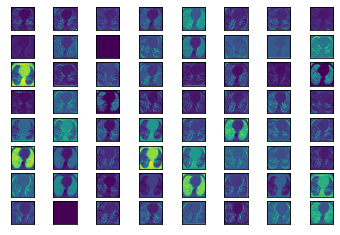

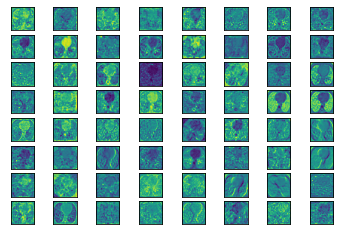

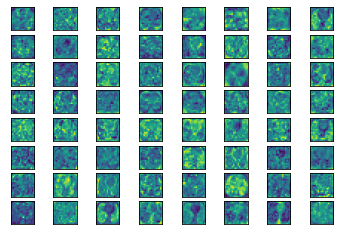

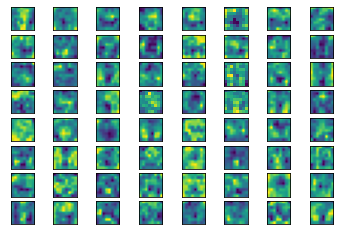

In [ ]:
fm_covid1 = generate_feature_maps(cov1)

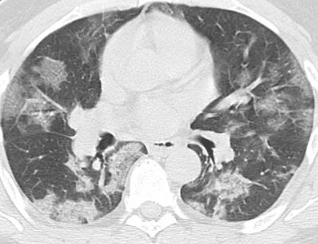

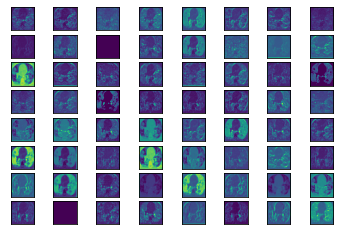

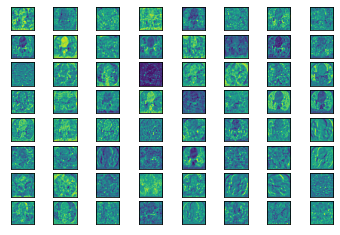

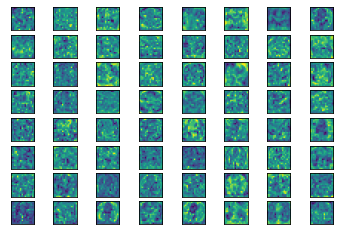

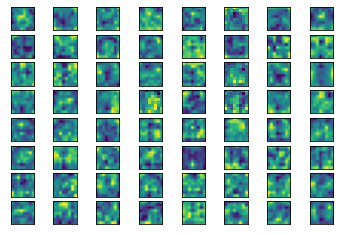

In [ ]:
fm_covid2 = generate_feature_maps(cov2)

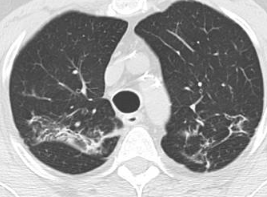

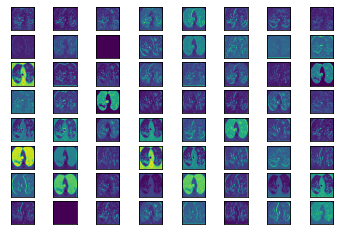

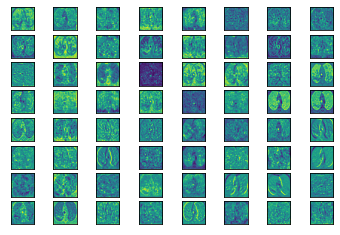

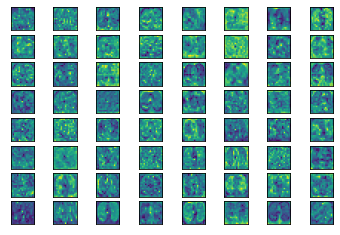

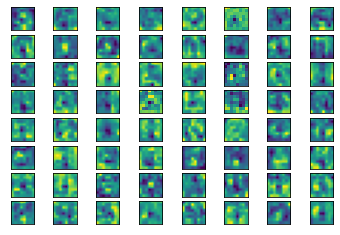

In [ ]:
fm_covid3 = generate_feature_maps(cov3)

### Non-COVID-19

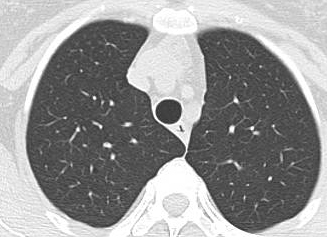

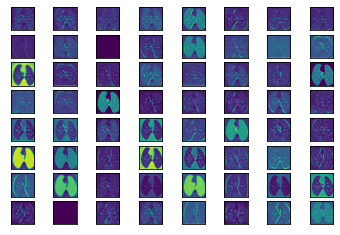

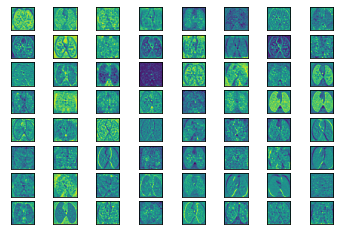

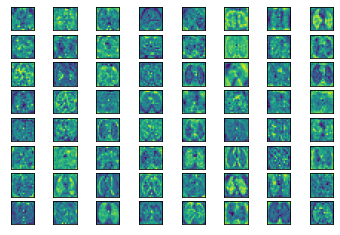

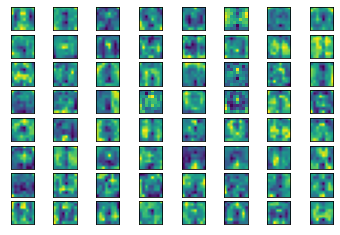

In [ ]:
fm_noncovid1 = generate_feature_maps(noncov1)

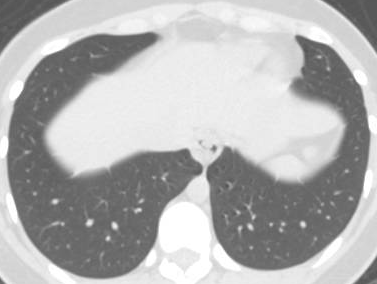

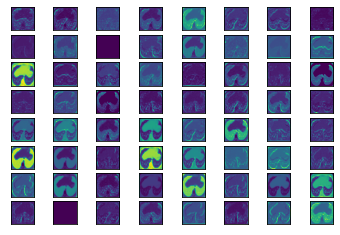

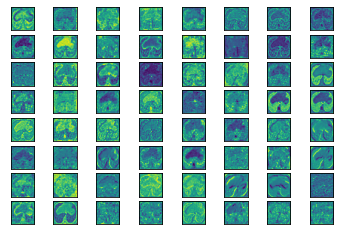

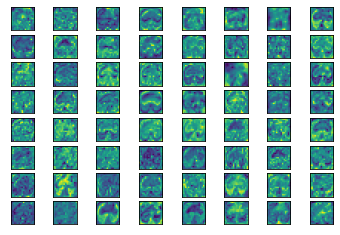

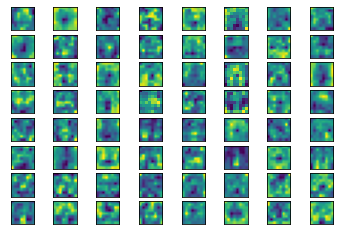

In [ ]:
fm_noncovid2 = generate_feature_maps(noncov2)

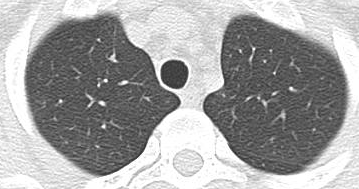

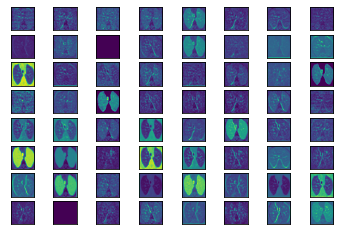

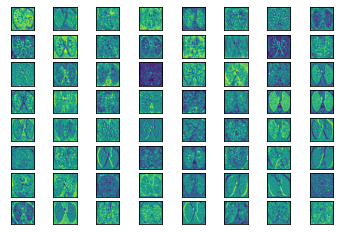

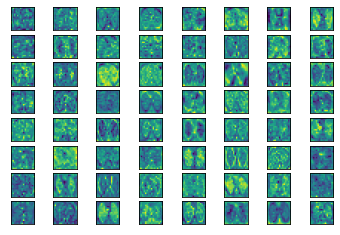

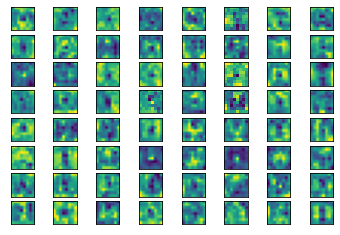

In [ ]:
fm_noncovid3 = generate_feature_maps(noncov3)

### False Negative

In [ ]:
fn_1 = 'Data/Test/COVID-19/AnotaGÇí+¦o 2020-05-05 220027.png'
fn_2 = 'Data/Test/COVID-19/AnotaGÇí+¦o 2020-05-05 220118.png'
fn_3 = 'Data/Test/COVID-19/AnotaGÇí+¦o 2020-05-05 220259.png'
fn_4 = 'Data/Test/COVID-19/AnotaGÇí+¦o 2020-05-05 220313.png'
fn_5 = 'Data/Test/COVID-19/AnotaGÇí+¦o 2020-05-05 220340.png'
fn_6 = 'Data/Test/COVID-19/AnotaGÇí+¦o 2020-05-05 220354.png'

In [ ]:
fm_fn1 = generate_feature_maps(fn_1)

In [ ]:
fm_fn2 = generate_feature_maps(fn_2)

In [ ]:
fm_fn3 = generate_feature_maps(fn_3)

In [ ]:
fm_fn4 = generate_feature_maps(fn_4)

In [ ]:
fm_fn5 = generate_feature_maps(fn_5)

In [ ]:
fm_fn6 = generate_feature_maps(fn_6)

### False Positive

In [ ]:
fp_1 = 'Data/Test/Non-COVID-19/Captura de Tela 2020-05-30 +ás 04.07.09.png'
fp_2 = 'Data/Test/Non-COVID-19/Captura de Tela 2020-05-30 +ás 04.07.22.png'
fp_3 = 'Data/Test/Non-COVID-19/Captura de Tela 2020-05-30 +ás 04.07.36.png'
fp_4 = 'Data/Test/Non-COVID-19/Captura de Tela 2020-05-30 +ás 04.42.18.png'
fp_5 = 'Data/Test/Non-COVID-19/Captura de Tela 2020-05-30 +ás 04.42.34.png'

In [ ]:
fm_fp1 = generate_feature_maps(fp_1)

In [ ]:
fm_fp2 = generate_feature_maps(fp_2)

In [ ]:
fm_fp3 = generate_feature_maps(fp_3)

In [ ]:
fm_fp4 = generate_feature_maps(fp_4)

In [ ]:
fm_fp5 = generate_feature_maps(fp_5)